In [1]:
from typing import List, Tuple, Union
from datetime import datetime, timedelta
import math
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATv2Conv, GCNConv, GATConv, SAGEConv
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from argparse import Namespace
import gc
import wandb


# loading Data

In [2]:

df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
edges = pd.read_csv('./data/edges.csv')
# 查看test 是否全没有出现
test_no_see_count = len(set(test_df['id'].unique()) - set(df['id'].unique()))
test_no_see_count == test_df['id'].nunique()

# 查看test是否在 edge中出现
no_edge_count = len(
    set(edges['id_1'].tolist() + edges['id_2'].tolist()) - 
    set(test_df['id'].unique()) - 
    set(df['id'].unique())
)


total_node = sorted(set(edges['id_1'].tolist() + edges['id_2'].tolist()))
lb_ecoder = LabelEncoder()
lb_ecoder.fit(np.array(total_node))
edges['id_1_idx'] = lb_ecoder.transform(edges['id_1'])
edges['id_2_idx'] = lb_ecoder.transform(edges['id_2'])


label_df = pd.DataFrame(np.array(total_node), columns=['id'])
label_df['id_idx'] = lb_ecoder.transform(label_df['id'])
label_df = label_df.merge(df, how='left', on='id')
label_df['target'] = label_df['target'].fillna(-1)


# dataLoader

In [3]:

class graphData(InMemoryDataset):
    def __init__(self, root, label_df_in, data_type='train', random_sample_ratio=0.3, random_graph_count=1024):
        self.idx = {
            'train': 0, 'val': 1, 'test': 2
        }[data_type]
        label_df_in = label_df_in.copy(deep=True).sort_values(by='id_idx', ignore_index=True)
        self.mask = torch.tensor(label_df_in['target'] != -1)
        self.node_features = torch.LongTensor(label_df_in['id_idx'].values)
        self.node_label = torch.tensor(label_df_in['target'].values).float()
        self.node_info = label_df_in['id'].values
        self.random_sample_ratio = random_sample_ratio
        self.random_graph_count = random_graph_count
        super().__init__(root)
        self.data, self.slices = torch.load(self.processed_paths[self.idx])


    @property
    def processed_file_names(self):
        return ['edge_processed__tr.dataset', 'edge_processed__val.dataset', 'edge_processed__test.dataset']


    def process(self):
        data_list = []
        if self.idx == 2:
            edges_smaple = edges.reset_index(drop=True).copy(deep=True)
            data = Data(
                x=self.node_features, 
                edge_index=torch.LongTensor(edges_smaple[['id_1_idx', 'id_2_idx']].values.T),
                y=self.node_label,
                mask=self.mask,
                x_info=self.node_info
            )
            data_list.append(data)
            data, slices = self.collate(data_list)
            torch.save((data, slices), self.processed_paths[self.idx])  
            return None
        
        # random node sampling
        for _ in tqdm(range(self.random_graph_count), total=self.random_graph_count):
            sample_nodes = np.random.choice(self.node_info, size=int(0.01 * len(self.node_info)), replace=False)
            neighbor1 = edges.loc[edges.id_1.isin(sample_nodes), 'id_2'].unique().tolist()
            tt_nodes = list(set(list(sample_nodes)) | set(neighbor1))
            edges_smaple = edges[edges.id_1.isin(tt_nodes)].reset_index(drop=True)
            data = Data(
                x=self.node_features, 
                edge_index=torch.LongTensor(edges_smaple[['id_1_idx', 'id_2_idx']].values.T),
                y=self.node_label,
                mask=self.mask,
                x_info=self.node_info
            )
            data_list.append(data)

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[self.idx])   
        return None
        

In [4]:
# dataloader
tr_dataset = graphData('./data/', label_df, data_type='train', random_sample_ratio=0.1, random_graph_count=128)
val_dataset = graphData('./data/', label_df, data_type='val', random_sample_ratio=0.1, random_graph_count=64)
te_dataset = graphData('./data/', label_df, data_type='test', random_sample_ratio=0.1, random_graph_count=64)

Processing...
100%|██████████| 128/128 [00:01<00:00, 65.93it/s]
Done!
Processing...
100%|██████████| 64/64 [00:00<00:00, 67.72it/s]
Done!
Processing...
Done!


# Model 

In [32]:

class GAT(torch.nn.Module):
    def __init__(self, num_emb, emb_dim=128, heads=8, hidden_c=16):
        super().__init__()
        self.node_emb = nn.Embedding(num_embeddings=num_emb, embedding_dim=emb_dim)
        
        self.conv1 = GATConv(emb_dim, hidden_c, heads, dropout=0.5)
        self.conv2 = GATConv(hidden_c * heads, hidden_c, heads, dropout=0.5)
        # self.conv3 = GATConv(hidden_c * heads, hidden_c, heads, dropout=0.4)
        self.conv4 = GATConv(hidden_c * heads, 2, heads=1,
                             concat=False, dropout=0.5)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # [b, n, emb_dim]
        x = self.node_emb(x)
        x = x.squeeze(1) 
        
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv1(x, edge_index))
        
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.conv2(x, edge_index))

        # x = F.dropout(x, p=0.3, training=self.training)
        # x = F.relu(self.conv3(x, edge_index))

        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv4(x, edge_index)
        return x



# Triaining 

In [66]:

def trainer(train_loader, valid_loader, model, config):
    device = config.device
    model.to('cpu')
    model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr) 
    save_path = config.save_path

    if not os.path.isdir('./models'):
        os.mkdir('./models')

    wandb.login()
    cfg_dict = config.__dict__
    wandb.init(
        project="XUNFEI-social-GAT",
        config=cfg_dict
    )

    n_epochs, best_loss, step, early_stop_count = config.n_epochs, math.inf, 0, 0
    ep_val_loss_collect = []
    for epoch in range(n_epochs):
        gc.collect()
        torch.cuda.empty_cache()
        model.train()
        loss_record = []
        train_pbar = tqdm(train_loader, position=0, leave=True)
        train_pbar.set_description(f'Epoch [{epoch+1:02d}/{n_epochs:02d} ]')
        ep_right_count = 0
        tt_count = 0
        t_cnt = 0
        tp_cnt = 0
        for data in train_pbar:
            optimizer.zero_grad() 
            data = data.to(device)
            label = data.y.to(device)
            pred = model(data)
            mask = data.mask
            loss = loss_fn(pred[mask], label[mask].long())
            tt_count += label[mask].size(0)
            ep_right_count += torch.sum(pred[mask].argmax(dim=1) == label[mask]).cpu().detach().item()
            loss.backward()
            optimizer.step()
            
            step += 1
            l_ = loss.detach().item()
            loss_record.append(l_)
            t_cnt += torch.sum(1.0 * (pred[mask].argmax(dim=1) == 1)).cpu().detach().item()
            tp_cnt += torch.sum((pred[mask].argmax(dim=1) == 1) & (label[mask] == 1)).cpu().detach().item()
            p_ = tp_cnt / (t_cnt + 1e-5) * 100
            train_pbar.set_postfix({'loss': f'{l_:.5f}', 'acc': '{:.5f}'.format(ep_right_count/tt_count), 'percision': '{:.2f}%'.format(p_) })
        
        mean_train_loss = sum(loss_record)/len(loss_record)
        mean_train_acc = ep_right_count/tt_count * 100
        tr_percision = tp_cnt / (t_cnt + 1e-5) * 100
        model.eval()
        loss_record = []
        ep_right_count = 0
        tt_count = 0
        t_cnt = 0
        tp_cnt = 0
        for data in valid_loader:
            data = data.to(device)
            label = data.y.to(device)
            with torch.no_grad():
                pred = model(data)
                mask = data.mask
                loss = loss_fn(pred[mask], label[mask].long())
                tt_count += label[mask].size(0)
                ep_right_count += torch.sum(pred[mask].argmax(dim=1) == label[mask]).cpu().detach().item()
                
                t_cnt += torch.sum((1* (pred[mask].argmax(dim=1) == 1)).float()).cpu().detach().item()
                tp_cnt += torch.sum((pred[mask].argmax(dim=1) == 1) & (label[mask] == 1)).cpu().detach().item()

            loss_record.append(loss.item())
        
        val_percision = tp_cnt / (t_cnt + 1e-5) * 100
        mean_valid_loss = sum(loss_record)/len(loss_record)
        mean_valid_acc = ep_right_count/tt_count * 100
        ep_val_loss_collect.append(mean_valid_loss)
        print(f"""Epoch [{epoch+1:02d}/{n_epochs:02d}]: 
                    Train loss: {mean_train_loss:.4f} Acc: {mean_train_acc:.2f}% Percision: {tr_percision:.2f}%
                    Valid loss: {mean_valid_loss:.4f} Acc: {mean_valid_acc:.2f}% Percision: {val_percision:.2f}%
        """)
        log_dict = {
            "TrainLoss": mean_train_loss,
            'TrainAcc': mean_train_acc,
            "TrainPercision": tr_percision,
            'ValLoss': mean_valid_loss,
            "ValAcc": mean_valid_acc,
            "ValPercision": val_percision,
            "bestLoss": best_loss
        }
        wandb.log(log_dict)
        if (epoch+1) % 10 == 0:
            dt_hhmm = datetime.now().strftime('%Y%m%d_%H%M')
            save_path_f = save_path.replace('.ckpt', f'_10ep_{dt_hhmm}.ckpt')
            torch.save(model.state_dict(), save_path_f) 
        
        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), save_path) 
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1


        if early_stop_count >= config.early_stop:
            print('\nModel is not improving, so we halt the training session.')
            break
    
    wandb.finish()
    return ep_val_loss_collect

In [68]:
gc.collect()
torch.cuda.empty_cache()

In [69]:
config = Namespace(
    device='cuda',
    n_epochs=40,
    save_path='./models/gnn-mid.ckpt',
    lr=5e-4,
    batch_size=3,
    early_stop=100,
    
    emb_dim=256,
    heads=8,
    hidden_c=32
)
train_loader = DataLoader(tr_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)


In [70]:
# model
model = GAT(num_emb=len(total_node), emb_dim=config.emb_dim, heads=config.heads, hidden_c=config.hidden_c)
loss_record = trainer(train_loader, valid_loader, model, config)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


TrainAcc,▁▅▆▇█
TrainLoss,█▄▂▁▁
TrainPercision,▁▃▄▆█
ValAcc,█▂▁▁▁
ValLoss,█▆▁▂▁
ValPercision,▁▁███
bestLoss,█▆▁▁
TrainAcc,72.63084
TrainLoss,0.6076
TrainPercision,1886.19194
ValAcc,73.88087


Epoch [01/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.84it/s, loss=0.72190, acc=0.70174, percision=30.15%]


Epoch [01/40]: 
                    Train loss: 0.8392 Acc: 70.17% Percision: 30.15%
                    Valid loss: 0.5904 Acc: 73.83% Percision: 41.47%
        
Saving model with loss 0.590...


Epoch [02/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.40it/s, loss=0.62596, acc=0.71455, percision=31.94%]


Epoch [02/40]: 
                    Train loss: 0.6661 Acc: 71.45% Percision: 31.94%
                    Valid loss: 0.5905 Acc: 73.87% Percision: 23.24%
        


Epoch [03/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.38it/s, loss=0.60583, acc=0.72327, percision=32.48%]


Epoch [03/40]: 
                    Train loss: 0.6163 Acc: 72.33% Percision: 32.48%
                    Valid loss: 0.5791 Acc: 73.88% Percision: 0.00%
        
Saving model with loss 0.579...


Epoch [04/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.69it/s, loss=0.59724, acc=0.72988, percision=33.22%]


Epoch [04/40]: 
                    Train loss: 0.5980 Acc: 72.99% Percision: 33.22%
                    Valid loss: 0.5807 Acc: 73.88% Percision: 0.00%
        


Epoch [05/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.57it/s, loss=0.58305, acc=0.73396, percision=34.46%]


Epoch [05/40]: 
                    Train loss: 0.5871 Acc: 73.40% Percision: 34.46%
                    Valid loss: 0.5690 Acc: 73.88% Percision: 0.00%
        
Saving model with loss 0.569...


Epoch [06/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.19it/s, loss=0.58266, acc=0.73571, percision=35.27%]


Epoch [06/40]: 
                    Train loss: 0.5800 Acc: 73.57% Percision: 35.27%
                    Valid loss: 0.5629 Acc: 73.88% Percision: 0.00%
        
Saving model with loss 0.563...


Epoch [07/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.52it/s, loss=0.57308, acc=0.73744, percision=43.51%]


Epoch [07/40]: 
                    Train loss: 0.5735 Acc: 73.74% Percision: 43.51%
                    Valid loss: 0.5640 Acc: 73.88% Percision: 88.24%
        


Epoch [08/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.32it/s, loss=0.56667, acc=0.73880, percision=49.98%]


Epoch [08/40]: 
                    Train loss: 0.5687 Acc: 73.88% Percision: 49.98%
                    Valid loss: 0.5552 Acc: 73.88% Percision: 0.00%
        
Saving model with loss 0.555...


Epoch [09/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.57it/s, loss=0.56304, acc=0.73975, percision=53.89%]


Epoch [09/40]: 
                    Train loss: 0.5633 Acc: 73.97% Percision: 53.89%
                    Valid loss: 0.5461 Acc: 73.88% Percision: 0.00%
        
Saving model with loss 0.546...


Epoch [10/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.67it/s, loss=0.56208, acc=0.74034, percision=55.83%]


Epoch [10/40]: 
                    Train loss: 0.5588 Acc: 74.03% Percision: 55.83%
                    Valid loss: 0.5422 Acc: 73.88% Percision: 0.00%
        
Saving model with loss 0.542...


Epoch [11/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.35it/s, loss=0.55013, acc=0.74079, percision=56.90%]


Epoch [11/40]: 
                    Train loss: 0.5545 Acc: 74.08% Percision: 56.90%
                    Valid loss: 0.5352 Acc: 73.88% Percision: 100.00%
        
Saving model with loss 0.535...


Epoch [12/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.53it/s, loss=0.54849, acc=0.74200, percision=59.18%]


Epoch [12/40]: 
                    Train loss: 0.5490 Acc: 74.20% Percision: 59.18%
                    Valid loss: 0.5281 Acc: 74.21% Percision: 84.02%
        
Saving model with loss 0.528...


Epoch [13/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.53it/s, loss=0.54523, acc=0.74290, percision=59.71%]


Epoch [13/40]: 
                    Train loss: 0.5455 Acc: 74.29% Percision: 59.71%
                    Valid loss: 0.5217 Acc: 74.50% Percision: 78.58%
        
Saving model with loss 0.522...


Epoch [14/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.49it/s, loss=0.53389, acc=0.74455, percision=60.31%]


Epoch [14/40]: 
                    Train loss: 0.5399 Acc: 74.45% Percision: 60.31%
                    Valid loss: 0.5129 Acc: 74.61% Percision: 80.04%
        
Saving model with loss 0.513...


Epoch [15/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.80it/s, loss=0.52892, acc=0.74637, percision=61.46%]


Epoch [15/40]: 
                    Train loss: 0.5335 Acc: 74.64% Percision: 61.46%
                    Valid loss: 0.5004 Acc: 74.99% Percision: 80.66%
        
Saving model with loss 0.500...


Epoch [16/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.22it/s, loss=0.51544, acc=0.74953, percision=62.80%]


Epoch [16/40]: 
                    Train loss: 0.5263 Acc: 74.95% Percision: 62.80%
                    Valid loss: 0.4876 Acc: 74.92% Percision: 83.17%
        
Saving model with loss 0.488...


Epoch [17/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.81it/s, loss=0.51120, acc=0.75408, percision=64.21%]


Epoch [17/40]: 
                    Train loss: 0.5170 Acc: 75.41% Percision: 64.21%
                    Valid loss: 0.4655 Acc: 75.92% Percision: 85.06%
        
Saving model with loss 0.465...


Epoch [18/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.84it/s, loss=0.49908, acc=0.76025, percision=67.03%]


Epoch [18/40]: 
                    Train loss: 0.5048 Acc: 76.03% Percision: 67.03%
                    Valid loss: 0.4380 Acc: 77.71% Percision: 87.72%
        
Saving model with loss 0.438...


Epoch [19/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.54it/s, loss=0.48073, acc=0.76877, percision=69.37%]


Epoch [19/40]: 
                    Train loss: 0.4901 Acc: 76.88% Percision: 69.37%
                    Valid loss: 0.4061 Acc: 80.08% Percision: 91.18%
        
Saving model with loss 0.406...


Epoch [20/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.72it/s, loss=0.46044, acc=0.78111, percision=73.15%]


Epoch [20/40]: 
                    Train loss: 0.4693 Acc: 78.11% Percision: 73.15%
                    Valid loss: 0.3573 Acc: 84.55% Percision: 91.99%
        
Saving model with loss 0.357...


Epoch [21/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.41it/s, loss=0.43516, acc=0.79498, percision=76.72%]


Epoch [21/40]: 
                    Train loss: 0.4455 Acc: 79.50% Percision: 76.72%
                    Valid loss: 0.3061 Acc: 88.78% Percision: 93.64%
        
Saving model with loss 0.306...


Epoch [22/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.25it/s, loss=0.41181, acc=0.80781, percision=80.23%]


Epoch [22/40]: 
                    Train loss: 0.4203 Acc: 80.78% Percision: 80.23%
                    Valid loss: 0.2662 Acc: 91.88% Percision: 93.96%
        
Saving model with loss 0.266...


Epoch [23/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.83it/s, loss=0.39094, acc=0.81817, percision=82.85%]


Epoch [23/40]: 
                    Train loss: 0.3985 Acc: 81.82% Percision: 82.85%
                    Valid loss: 0.2216 Acc: 93.85% Percision: 94.92%
        
Saving model with loss 0.222...


Epoch [24/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.45it/s, loss=0.37722, acc=0.82832, percision=85.74%]


Epoch [24/40]: 
                    Train loss: 0.3777 Acc: 82.83% Percision: 85.74%
                    Valid loss: 0.1904 Acc: 95.46% Percision: 94.20%
        
Saving model with loss 0.190...


Epoch [25/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.81it/s, loss=0.36565, acc=0.83468, percision=87.03%]


Epoch [25/40]: 
                    Train loss: 0.3612 Acc: 83.47% Percision: 87.03%
                    Valid loss: 0.1684 Acc: 96.15% Percision: 95.06%
        
Saving model with loss 0.168...


Epoch [26/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.43it/s, loss=0.34390, acc=0.83990, percision=88.46%]


Epoch [26/40]: 
                    Train loss: 0.3486 Acc: 83.99% Percision: 88.46%
                    Valid loss: 0.1515 Acc: 96.60% Percision: 95.76%
        
Saving model with loss 0.152...


Epoch [27/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.28it/s, loss=0.33674, acc=0.84343, percision=89.44%]


Epoch [27/40]: 
                    Train loss: 0.3392 Acc: 84.34% Percision: 89.44%
                    Valid loss: 0.1408 Acc: 97.00% Percision: 95.86%
        
Saving model with loss 0.141...


Epoch [28/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.73it/s, loss=0.33119, acc=0.84706, percision=89.94%]


Epoch [28/40]: 
                    Train loss: 0.3291 Acc: 84.71% Percision: 89.94%
                    Valid loss: 0.1353 Acc: 97.16% Percision: 96.89%
        
Saving model with loss 0.135...


Epoch [29/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.14it/s, loss=0.30980, acc=0.84959, percision=90.41%]


Epoch [29/40]: 
                    Train loss: 0.3213 Acc: 84.96% Percision: 90.41%
                    Valid loss: 0.1237 Acc: 97.44% Percision: 96.80%
        
Saving model with loss 0.124...


Epoch [30/40 ]: 100%|██████████| 43/43 [00:02<00:00, 14.90it/s, loss=0.31387, acc=0.85156, percision=90.77%]


Epoch [30/40]: 
                    Train loss: 0.3152 Acc: 85.16% Percision: 90.77%
                    Valid loss: 0.1153 Acc: 97.63% Percision: 96.56%
        
Saving model with loss 0.115...


Epoch [31/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.23it/s, loss=0.30519, acc=0.85329, percision=90.98%]


Epoch [31/40]: 
                    Train loss: 0.3095 Acc: 85.33% Percision: 90.98%
                    Valid loss: 0.1187 Acc: 97.63% Percision: 97.62%
        


Epoch [32/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.50it/s, loss=0.30480, acc=0.85488, percision=91.22%]


Epoch [32/40]: 
                    Train loss: 0.3051 Acc: 85.49% Percision: 91.22%
                    Valid loss: 0.1022 Acc: 97.95% Percision: 96.72%
        
Saving model with loss 0.102...


Epoch [33/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.30it/s, loss=0.30106, acc=0.85684, percision=91.43%]


Epoch [33/40]: 
                    Train loss: 0.3004 Acc: 85.68% Percision: 91.43%
                    Valid loss: 0.1037 Acc: 97.98% Percision: 97.35%
        


Epoch [34/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.94it/s, loss=0.29081, acc=0.85793, percision=91.64%]


Epoch [34/40]: 
                    Train loss: 0.2970 Acc: 85.79% Percision: 91.64%
                    Valid loss: 0.1004 Acc: 98.04% Percision: 97.64%
        
Saving model with loss 0.100...


Epoch [35/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.56it/s, loss=0.29082, acc=0.85934, percision=91.85%]


Epoch [35/40]: 
                    Train loss: 0.2936 Acc: 85.93% Percision: 91.85%
                    Valid loss: 0.0920 Acc: 98.24% Percision: 97.52%
        
Saving model with loss 0.092...


Epoch [36/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.29it/s, loss=0.28544, acc=0.86074, percision=91.99%]


Epoch [36/40]: 
                    Train loss: 0.2895 Acc: 86.07% Percision: 91.99%
                    Valid loss: 0.0970 Acc: 98.14% Percision: 97.89%
        


Epoch [37/40 ]: 100%|██████████| 43/43 [00:02<00:00, 14.96it/s, loss=0.28208, acc=0.86209, percision=92.12%]


Epoch [37/40]: 
                    Train loss: 0.2866 Acc: 86.21% Percision: 92.12%
                    Valid loss: 0.0871 Acc: 98.42% Percision: 97.81%
        
Saving model with loss 0.087...


Epoch [38/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.83it/s, loss=0.28341, acc=0.86323, percision=92.27%]


Epoch [38/40]: 
                    Train loss: 0.2834 Acc: 86.32% Percision: 92.27%
                    Valid loss: 0.0835 Acc: 98.51% Percision: 97.82%
        
Saving model with loss 0.083...


Epoch [39/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.57it/s, loss=0.28151, acc=0.86356, percision=92.14%]


Epoch [39/40]: 
                    Train loss: 0.2819 Acc: 86.36% Percision: 92.14%
                    Valid loss: 0.0788 Acc: 98.50% Percision: 97.77%
        
Saving model with loss 0.079...


Epoch [40/40 ]: 100%|██████████| 43/43 [00:02<00:00, 15.35it/s, loss=0.27668, acc=0.86433, percision=92.36%]


Epoch [40/40]: 
                    Train loss: 0.2793 Acc: 86.43% Percision: 92.36%
                    Valid loss: 0.0712 Acc: 98.68% Percision: 97.46%
        
Saving model with loss 0.071...


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


TrainAcc,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▄▄▄▅▆▆▆▇▇▇▇▇▇██████████
TrainLoss,█▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
TrainPercision,▁▁▁▁▁▂▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇███████████████
ValAcc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▇██████████████
ValLoss,████████▇▇▇▇▇▇▇▇▆▆▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
ValPercision,▄▃▁▁▁▁▇▁▁▁█▇▇▇▇▇▇▇▇▇████████████████████
bestLoss,████████▇▇▇▇▇▇▇▇▆▆▅▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
TrainAcc,86.43254
TrainLoss,0.27934
TrainPercision,92.36125
ValAcc,98.68158


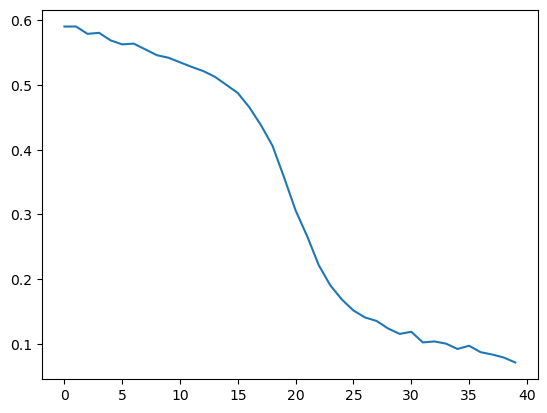

In [71]:
import matplotlib.pyplot as plt
plt.plot(loss_record)
plt.show()

# submit

In [74]:
gc.collect()
torch.cuda.empty_cache()
model.eval()
device = config.device
loss_record = []
test_accs = []
ep_right_count = 0
tt_count = 0
data = te_dataset[0]
data = data.to(device)
label = data.y.to(device)
with torch.no_grad():
    pred = model(data)
    mask = data.mask
    tt_count += label[mask].size(0)
    ep_right_count += torch.sum(pred[mask].argmax(dim=1) == label[mask]).cpu().detach().item()

In [75]:
t_cnt, tp_cnt = 0, 0
t_cnt += torch.sum(1.0 * (pred[mask].argmax(dim=1) == 1)).cpu().detach().item()
tp_cnt += torch.sum((pred[mask].argmax(dim=1) == 1) & (label[mask] == 1)).cpu().detach().item()
p_ = tp_cnt / (t_cnt + 1e-5)

t_cnt, tp_cnt, p_

(6422.0, 6011, 0.9360012442603531)

In [76]:
res = pd.DataFrame({
'id':  data.x_info,
'target': pred.argmax(dim=1).cpu().detach().numpy()
})
submit_df = pd.read_csv('./data/sample_submit.csv')
sub = submit_df[['id']].merge(res, how='left', on='id')
sub['target'].value_counts()

# 0.8286
# 0    8200
# 1    1800
# Name: target, dtype: int64

# sub_mid_0919_02 0.8281
# 0    8157
# 1    1843
# Name: target, dtype: int64

# sub_mid_20_03 0.8077
# 0    7665
# 1    2335
# Name: target, dtype: int64

# 0.8263 sub_mid_20_02
# 0    8273
# 1    1727
# Name: target, dtype: int64

0    8029
1    1971
Name: target, dtype: int64

In [77]:
label_df[label_df.target >=0].target.value_counts(normalize=True)

0.0    0.738809
1.0    0.261191
Name: target, dtype: float64

In [78]:
tt = 8200 + 1800
print(tt * 0.8286, (1 - 0.8286) * tt, 1800 - 1714.0 * 0.1)
# tp+fn=8286, tn+fp = 1714
# tp+tn=1800

for tn_rate in [0.05, 0.1, 0.15, 0.2, 0.25, 0.26, 0.27, 0.3, 0.5, 0.55]:
    tn = tn_rate * 1714
    tp = 1800 - tn
    fp = 1714 * (1 - tn_rate)
    fn = 8286 - tp
    a = np.array([tp, tn, fp, fn])
    a = np.round(a, 1)
    pos_cnt = a[0] + a[2]
    pos_rate = pos_cnt / tt * 100
    acc = (a[0] + a[3]) / tt * 100
    pecision = tp / (tn + tp) * 100
    print(f'tn_rate={tn_rate:.2f} a={a} positive={pos_cnt:.1f} pos_rate={pos_rate:.2f}% acc={acc:.2f}% pecision={pecision:.2f}%')

8286.0 1714.0 1628.6
tn_rate=0.05 a=[1714.3   85.7 1628.3 6571.7] positive=3342.6 pos_rate=33.43% acc=82.86% pecision=95.24%
tn_rate=0.10 a=[1628.6  171.4 1542.6 6657.4] positive=3171.2 pos_rate=31.71% acc=82.86% pecision=90.48%
tn_rate=0.15 a=[1542.9  257.1 1456.9 6743.1] positive=2999.8 pos_rate=30.00% acc=82.86% pecision=85.72%
tn_rate=0.20 a=[1457.2  342.8 1371.2 6828.8] positive=2828.4 pos_rate=28.28% acc=82.86% pecision=80.96%
tn_rate=0.25 a=[1371.5  428.5 1285.5 6914.5] positive=2657.0 pos_rate=26.57% acc=82.86% pecision=76.19%
tn_rate=0.26 a=[1354.4  445.6 1268.4 6931.6] positive=2622.8 pos_rate=26.23% acc=82.86% pecision=75.24%
tn_rate=0.27 a=[1337.2  462.8 1251.2 6948.8] positive=2588.4 pos_rate=25.88% acc=82.86% pecision=74.29%
tn_rate=0.30 a=[1285.8  514.2 1199.8 7000.2] positive=2485.6 pos_rate=24.86% acc=82.86% pecision=71.43%
tn_rate=0.50 a=[ 943.  857.  857. 7343.] positive=1800.0 pos_rate=18.00% acc=82.86% pecision=52.39%
tn_rate=0.55 a=[ 857.3  942.7  771.3 7428.7] po

In [79]:
sub.to_csv('./data/sub_mid_20_04.csv', index=False)

In [71]:
# sub = pd.read_csv('./data/sub_mid_20_04.csv')
# sub['target'].value_counts()

0    8280
1    1720
Name: target, dtype: int64

In [75]:
sub1 = pd.read_csv('./data/sub_mid_20_02.csv')
sub1['target'].value_counts()

sub2 = pd.read_csv('./data/sub_0919.csv')
sub2['target'].value_counts()

sub2.merge(sub1.rename(columns={'target': 't2'}), how='left', on='id')

,id,target,t2
0,00004509-7c0b-41d8-bef4-30d85c1de29d,0,0
1,000c248a-b598-42b5-a9fb-73709ee10c26,1,1
2,00113a82-dfac-4293-b1ad-f0b4e39d9717,0,0
3,001dd7c7-3cb3-43e0-97b7-e2e4766cb052,0,0
4,002cc686-0f40-42e7-82e1-05723961dc40,1,0
...,...,...,...
9995,ffe68f81-ad8d-4152-9f34-f0d45f65dc6e,0,0
9996,ffe8fb98-231a-42cc-98a5-2f4a636679cf,1,1
9997,ffeba678-e53b-4228-bed2-7d7036245752,0,0
9998,fff10e16-f1fd-46de-b8c7-8f847f572fa8,0,0
